In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [3]:
movil = pd.read_csv('datasets/Telefonia_movil.csv', dayfirst=True, thousands='.')
movil.tail()

,Año,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo
17,2017,2,15315167,6293563,21608730,Abr-Jun 2017
18,2017,3,15106275,6308373,21414647,Jul-Sept 2017
19,2017,4,14164552,5380710,19545262,Oct-Dic 2017
20,2018,1,13851254,5958717,19809971,Ene-Mar 2018
21,2018,2,14388755,6290155,20678910,Abr-Jun 2018


In [4]:
movil.index = pd.PeriodIndex(movil['Año'].astype(str) + 'Q' + movil['Trimestre'].astype(str), freq='Q')
movil.head()

,Año,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo
2013Q1,2013,1,8785943,6582117,15368060,Ene-Mar 2013
2013Q2,2013,2,9512689,7108640,16621329,Abr-Jun 2013
2013Q3,2013,3,10315484,7335154,17650638,Jul-Sept 2013
2013Q4,2013,4,9809515,6250549,16060064,Oct-Dic 2013
2014Q1,2014,1,10128751,5799223,15927974,Ene-Mar 2013


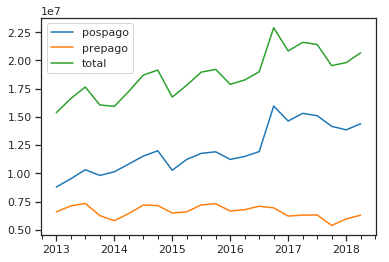

In [5]:
movil['pospago'] = movil['Minutos pospago salientes (miles)']
movil['prepago'] = movil['Minutos prepago salientes (miles)']
movil['total'] = movil['Total de minutos salientes (miles)']
columns = [
    'pospago',
    'prepago',
    'total',
]
movil[columns].plot()

In [6]:
movil[columns].describe()

,pospago,prepago,total
count,2.200000e+01,2.200000e+01,2.200000e+01
mean,1.209691e+07,6.604273e+06,1.870118e+07
std,2.077349e+06,5.251805e+05,1.990543e+06
min,8.785943e+06,5.380710e+06,1.536806e+07
25%,1.044198e+07,6.291007e+06,1.735731e+07
50%,1.164553e+07,6.580968e+06,1.883452e+07
75%,1.408623e+07,7.100940e+06,1.974379e+07
max,1.596076e+07,7.335154e+06,2.289966e+07


In [7]:
y = movil.total

In [8]:
## Random walk
h = 4
test=pd.period_range(start=y.index[-1]+1, periods=h, freq='Q')
pred=pd.Series(np.repeat(y.iloc[-1], h), index=test) # the forecast repeats the last observed values h times
pred

2018Q3    20678910
2018Q4    20678910
2019Q1    20678910
2019Q2    20678910
Freq: Q-DEC, dtype: int64

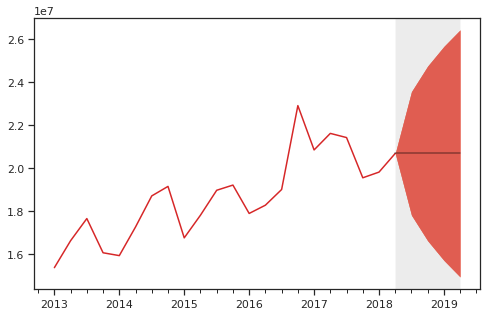

In [9]:
fitted_naive = y.shift(1)
resid=y-fitted_naive # the shift lags the series by one period
sigma = resid.std()
round(sigma,3)
intv = pd.concat([pred-stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1)),
                   pred+stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)
intv.round(3)

from plotting import fanchart

point_pred = (intv[0]+intv[1])/2

fig, ax = fanchart(y['2010':],point_pred,intv,intv,intv)

plt.show()

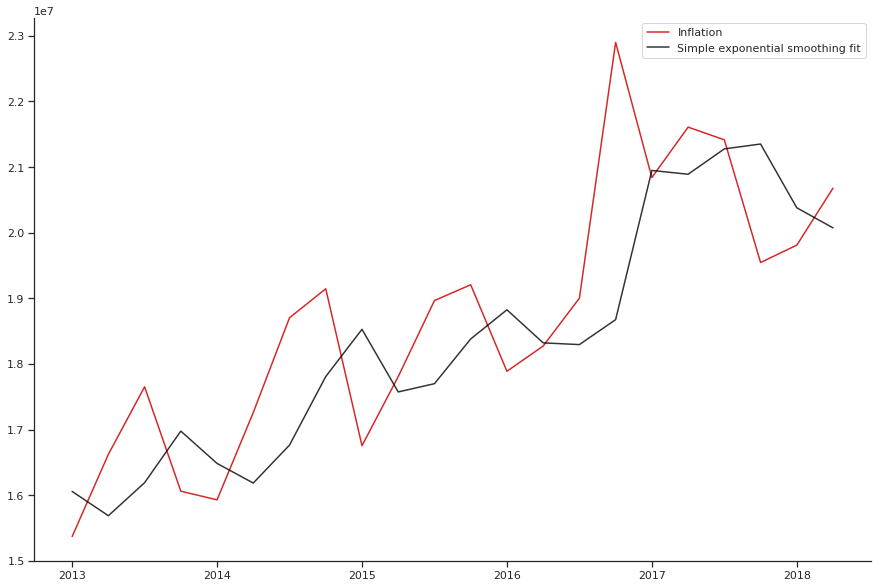

In [10]:
## Simple Exponential Smoothing

model_ses = sm.tsa.SimpleExpSmoothing(y).fit()
fitted_ses = model_ses.fittedvalues

# plot
fig, ax= plt.subplots(figsize=(15,10))
y.plot(color=red, label='Inflation')
fitted_ses.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
# ax.set_ylabel('Inflation')
# ax.set_title('Australian Quarterly CPI Inflation')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

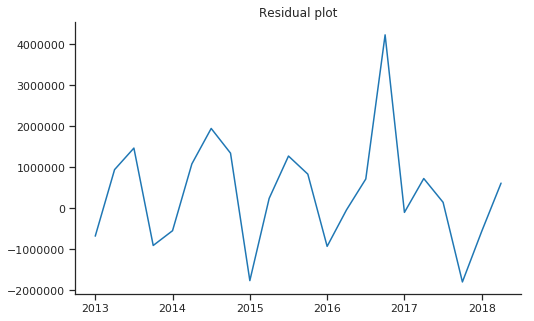

In [11]:
resid=y-fitted_ses

fig, ax= plt.subplots(figsize=(8,5))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()


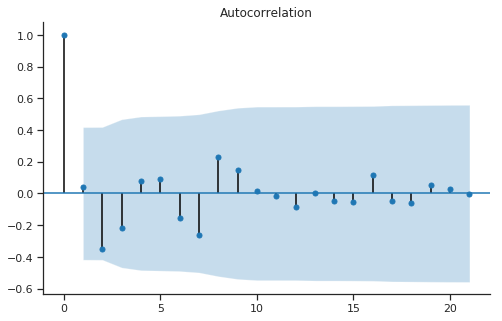

In [12]:
fig, ax = plt.subplots(figsize=(8,5))
sm.graphics.tsa.plot_acf(resid, lags=21, ax=ax)
sns.despine()
plt.show()

/home/emanuel/.virtualenvs/series-temporales/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


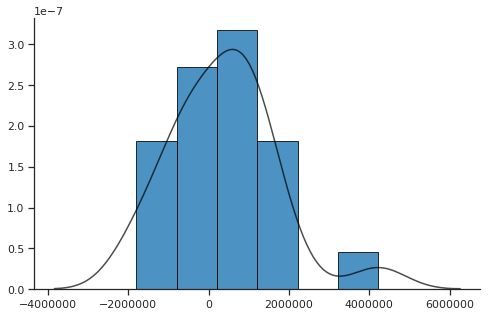

In [13]:
def hist(series):
    fig, ax= plt.subplots(figsize=(8,5))
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

hist(resid)
plt.show()

In [15]:
# Real time forecasting - use it as a template - expanding window

validation=y['2014Q4':].index # the validation period is Q1 2004 onwards
start = y.index.get_loc('2014Q4') # numerical index corresponding to Q1 2005

pred1 = []
pred2 = []
actual= []
for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-1]) # random walk forecast
    
    model = sm.tsa.SimpleExpSmoothing(y.iloc[:i]).fit() 
    pred2.append(model.forecast(1)[0]) # SES forecast

columns=['RW', 'SES', 'Actual']
results_sm = np.vstack([pred1,pred2,actual]).T
results_sm = pd.DataFrame(results_sm, columns=columns, index=validation)
results_sm

,RW,SES,Actual
2014Q4,18703495.0,1.870350e+07,19144961.0
2015Q1,19144961.0,1.914496e+07,16753809.0
2015Q2,16753809.0,1.675381e+07,17806395.0
2015Q3,17806395.0,1.762396e+07,18965537.0
2015Q4,18965537.0,1.816764e+07,19206111.0
2016Q1,19206111.0,1.872956e+07,17887638.0
2016Q2,17887638.0,1.831596e+07,18271759.0
2016Q3,18271759.0,1.830067e+07,19001229.0
2016Q4,19001229.0,1.860414e+07,22899656.0
2017Q1,22899656.0,2.289966e+07,20840252.0


In [16]:

from scipy import stats

table = pd.DataFrame(0.0, index=results_sm.columns[:-1], columns=['RMSE','SE', 'MAPE'])
for i in range(2):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results_sm.iloc[:,i], results_sm.iloc[:,-1])
    a = results_sm.iloc[:,i] - results_sm.iloc[:,-1]
    table.iloc[i,1] = (results_sm.iloc[:,i] - results_sm.iloc[:,-1]).sem()
    table.iloc[i,2] = ((results_sm.iloc[:,i] - results_sm.iloc[:,-1]) / results_sm.Actual).sem()
    
table.round(3)

,RMSE,SE,MAPE
RW,1532466.434,408053.741,0.020
SES,1602640.365,425679.170,0.021
